# Projet - Detection d'URLs malicieuses à l'aide du machine learning (scikit-learn)

Auteurs : Quentin PAUWELS & Samuel ISRAEL

In [23]:
# Importations
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sn

# Scikit-learn importations
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

## Chargement du dataset

In [24]:
from urllib.parse import urlparse

# Chargement dataset
print("===== Chargement CSV Data =====")
#urls_data = pd.read_csv("urldataBigBg.csv", usecols=['url', 'label'])
urls_data = pd.read_csv("urldata.csv")


# Donner le nom des 2 colonnes importantes pour le dataset utilisé
name_url_column_for_the_dataset = 'URLs'
name_class_column_for_the_dataset = 'Class'

# Créer les colonnes 'URLs' et 'Class' à partir des noms de colonnes du dataset utilisé
urls_data['URLs'] = urls_data[name_url_column_for_the_dataset]
urls_data['Class'] = urls_data[name_class_column_for_the_dataset]

# Remplace le terme 'good' ou 'benign' par 0, le reste par 1
urls_data['Class'] = urls_data['Class'].apply(lambda y: 0 if y == 'good' or y == 'benign' else 1)

urls_data['Class'].value_counts()
urls_data = urls_data[['URLs', 'Class']]
urls_data.head()

===== Chargement CSV Data =====


,URLs,Class
0,https://www.google.com,0
1,https://www.youtube.com,0
2,https://www.facebook.com,0
3,https://www.baidu.com,0
4,https://www.wikipedia.org,0


### Ajout de caractéristiques au dataset

Les fonctions pour l'ajout de caractéristiques sont fortement inspirées de celles présentent sur le site : https://www.kaggle.com/code/siddharthkumar25/detect-malicious-url-using-ml

In [25]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

#Longueur premier dossier
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

#Utilisation d'une IP
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)
    if match:
        return 0
    else:
        return 1        

def add_criterias(urls_data):
    #Criteres d'occurences
    urls_data['count-digits'] = urls_data['URLs'].apply(lambda y: digit_count(y))
    urls_data['count-dir'] = urls_data['URLs'].apply(lambda y: no_of_dir(y))
    urls_data['count.'] = urls_data['URLs'].apply(lambda y: y.count('.'))
    urls_data['count-'] = urls_data['URLs'].apply(lambda y: y.count('-'))
    urls_data['count_'] = urls_data['URLs'].apply(lambda y: y.count('_'))
    urls_data['count@'] = urls_data['URLs'].apply(lambda y: y.count('@'))
    urls_data['count?'] = urls_data['URLs'].apply(lambda y: y.count('?'))
    urls_data['count%'] = urls_data['URLs'].apply(lambda y: y.count('%'))
    urls_data['count='] = urls_data['URLs'].apply(lambda y: y.count('='))
    urls_data['count-http'] = urls_data['URLs'].apply(lambda y : y.count('http'))
    urls_data['count-https'] = urls_data['URLs'].apply(lambda y : y.count('https'))
    urls_data['count-www'] = urls_data['URLs'].apply(lambda y: y.count('www'))
    urls_data['count-letters'] = urls_data['URLs'].apply(lambda y: letter_count(y))

    #Criteres de longueur
    urls_data['url_length'] = urls_data['URLs'].apply(lambda y: len(str(y)))
    urls_data['hostname_length'] = urls_data['URLs'].apply(lambda y: len(urlparse(y).netloc))
    urls_data['path_length'] = urls_data['URLs'].apply(lambda y: len(urlparse(y).path))
    urls_data['fd_length'] = urls_data['URLs'].apply(lambda y: fd_length(y))

    urls_data['use_of_ip'] = urls_data['URLs'].apply(lambda y: having_ip_address(y))

    return urls_data

urls_data = add_criterias(urls_data)
urls_data.head()    

,URLs,Class,count-digits,count-dir,count.,count-,count_,count@,count?,count%,count=,count-http,count-https,count-www,count-letters,url_length,hostname_length,path_length,fd_length,use_of_ip
0,https://www.google.com,0,0,0,2,0,0,0,0,0,0,1,1,1,17,22,14,0,0,1
1,https://www.youtube.com,0,0,0,2,0,0,0,0,0,0,1,1,1,18,23,15,0,0,1
2,https://www.facebook.com,0,0,0,2,0,0,0,0,0,0,1,1,1,19,24,16,0,0,1
3,https://www.baidu.com,0,0,0,2,0,0,0,0,0,0,1,1,1,16,21,13,0,0,1
4,https://www.wikipedia.org,0,0,0,2,0,0,0,0,0,0,1,1,1,20,25,17,0,0,1


In [26]:
def results(model, test_data, test_labels):
    # Utiliser le modèle entraîné pour prédire des étiquettes de sortie pour les données de test
    pred_labels = model.predict(test_data)

    #Calcule l'accuracy
    accuracy = model.score(test_data, test_labels)

    # Calcule le score f1
    f1 = f1_score(test_labels, pred_labels)

    # Calcule le score recall
    recall = recall_score(test_labels, pred_labels)

    # Matrice de confusion
    cm = confusion_matrix(test_labels, pred_labels)
    ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['good', 'bad']).plot()

    return (accuracy, f1, recall, pred_labels)

def printResults(accuracy, f1, recall, test_labels, pred_labels):
    # Afficher l'accuracy du modèle
    print("Accuracy : ", accuracy)

    #Afficher le score F1 du modèle
    print("Score F1 : ", f1)

    #Afficher le recall du modèle
    print("Recall : ", recall)

    # Afficher la matrice de confusion
    print(classification_report(test_labels, pred_labels))
 
    #print(confusion_matrix(test_labels, pred_labels))


## Dataset d'entrainement et de test

In [27]:
# Split intro training and testing data sets
print("===== Séparation dataset entrainement et test =====")
train_data, test_data = train_test_split(urls_data, test_size=0.2, random_state=42)

labels = train_data['Class']
test_labels = test_data['Class']

#test_data = test_data.drop(['Class'], axis = 1)

print("Debut du dataset de test :")
test_data.head()

===== Séparation dataset entrainement et test =====
Debut du dataset de test :


,URLs,Class,count-digits,count-dir,count.,count-,count_,count@,count?,count%,count=,count-http,count-https,count-www,count-letters,url_length,hostname_length,path_length,fd_length,use_of_ip
367504,http://centralassociatesltd.com/richieeee/inde...,1,0,2,2,0,0,0,0,0,0,1,0,0,44,51,24,20,9,1
286248,https://www.sbsmnlaw.com/attorney-profiles/,0,0,2,2,1,0,0,0,0,0,1,1,1,35,43,16,19,17,1
180683,https://www.encyclopedia.com/video/dr_g23qi9hg...,0,3,2,3,5,1,0,0,0,0,1,1,1,65,82,20,54,5,1
156395,https://www.californiabeat.org/2010/08/02/the-...,0,8,4,2,9,0,0,0,0,0,1,1,1,67,93,22,63,4,1
159544,https://www.ccdr.org/joan_p_kealiinohomoku.html,0,0,1,3,0,2,0,0,0,0,1,1,1,38,47,12,27,26,1


===== Informations sur les 2 dataset résultants =====

Longueur data set entrainement : 360140
Longueur data set test : 90036


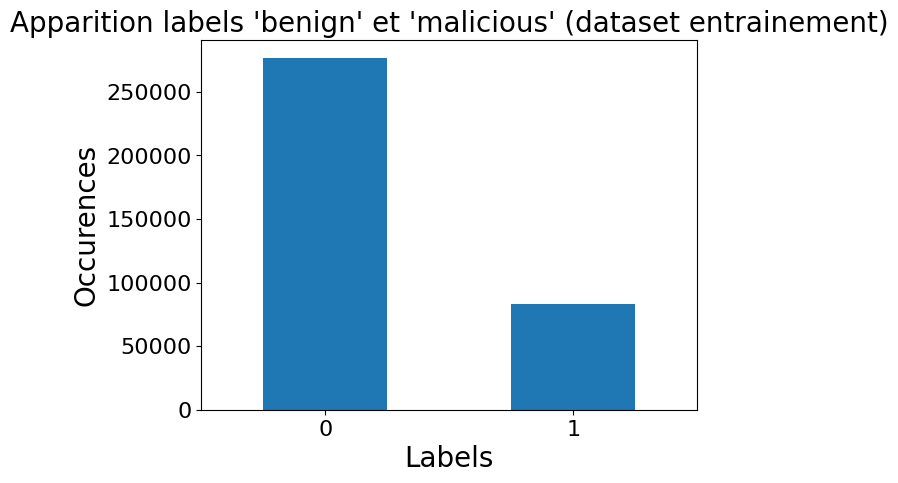

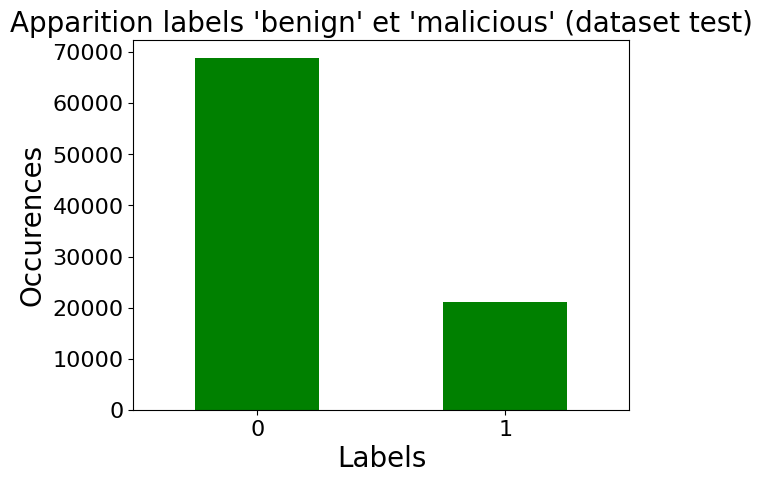

In [28]:
print("===== Informations sur les 2 dataset résultants =====")
print()
print("Longueur data set entrainement :", len(train_data))
print("Longueur data set test :", len(test_data))

# Graphes pour compter le nombre de "good" et "bad" pour chaque dataset
count_train_classes = pd.value_counts(train_data['Class'])
count_train_classes.plot(kind='bar', fontsize=16)
plt.title("Apparition labels 'benign' et 'malicious' (dataset entrainement)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Labels", fontsize=20)
plt.ylabel("Occurences", fontsize=20)

plt.show()

count_test_classes = pd.value_counts(test_data['Class'])
count_test_classes.plot(kind='bar', fontsize=16, colormap='ocean')
plt.title("Apparition labels 'benign' et 'malicious' (dataset test)", fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Labels", fontsize=20)
plt.ylabel("Occurences", fontsize=20)

plt.show()

## Partie avec tokenizer

Le code du tokenizer suivant provient du site : https://github.com/NetsecExplained/Machine-Learning-for-Security-Analysts

In [29]:
# Definition du tokenizer

def tokenizer(url): 
  # Split by slash (/) and dash (-)
  tokens = re.split('[/-]', url)
  for i in tokens:   
    # Include the splits extensions and subdomains
    if i.find(".") >= 0:
      dot_split = i.split('.')
      # Remove .com and www. since they're too common
      if "com" in dot_split:
        dot_split.remove("com")
      if "www" in dot_split:
        dot_split.remove("www")
      
      tokens += dot_split
    
    try: 
      while(tokens.index('')):
        tokens.remove('')
    except:
        pass
  return tokens

In [30]:
# Vectorisation des dataset

# CountVectorizer
cVec = CountVectorizer(tokenizer=tokenizer)
count_X = cVec.fit_transform(train_data['URLs'])

# TfidfVectorizer
tVec = TfidfVectorizer(tokenizer=tokenizer)
tfidf_X = tVec.fit_transform(train_data['URLs'])

In [31]:
test_count_X = cVec.transform(test_data['URLs'])
test_tfidf_X = tVec.transform(test_data['URLs'])

### Explication rapide de CountVectorizer, TfidfVectorizer et ma fonction tokenizer

In [32]:
# Definir l'URL
fake_url = "https://www.google.com//detect-malicious-url-from-url-database/page2"
print("URL factice : ",fake_url)
print("Tokens de l'URL factice : ", tokenizer(fake_url))

URL factice :  https://www.google.com//detect-malicious-url-from-url-database/page2
Tokens de l'URL factice :  ['https:', 'www.google.com', 'detect', 'malicious', 'url', 'from', 'url', 'database', 'page2', 'google']


In [33]:
# Définir les données
#data = ["https://www.google.com/detect-malicious-url-from-url-database/page2"]
data = ["https://www.google.com/detect-malicious-url-from-url-database/page2", "https://www.google.com/detect-malicious-url/page2"]

# CountVectorizer
print("===== Avec CountVectorizer =====")

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)
pd.DataFrame(X.toarray(),columns= vectorizer.get_feature_names_out())

===== Avec CountVectorizer =====


,com,database,detect,from,google,https,malicious,page2,url,www
0,1,1,1,1,1,1,1,1,2,1
1,1,0,1,0,1,1,1,1,1,1


In [34]:
# TfidfVectorizer
print("===== Avec TfidfVectorizer =====")

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
pd.DataFrame(X.toarray(),columns= vectorizer.get_feature_names_out())

===== Avec TfidfVectorizer =====


,com,database,detect,from,google,https,malicious,page2,url,www
0,0.258625,0.363488,0.258625,0.363488,0.258625,0.258625,0.258625,0.258625,0.517249,0.258625
1,0.353553,0.000000,0.353553,0.000000,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553


### Modele : Multinomial Naive Bayesian

===== Modele : Multinomial Naive Bayesian avec TfidfVectorizer =====
Accuracy :  0.9900817450797459
Score F1 :  0.9785537596964383
Recall :  0.9648591049017287
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     68921
           1       0.99      0.96      0.98     21115

    accuracy                           0.99     90036
   macro avg       0.99      0.98      0.99     90036
weighted avg       0.99      0.99      0.99     90036



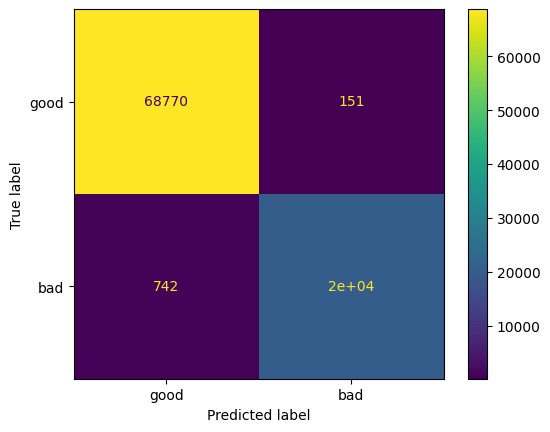

In [35]:
print("===== Modele : Multinomial Naive Bayesian avec TfidfVectorizer =====")
# Entrainement du modèle
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_X, labels)

# Calcule et affiche les résultats
score_mnb_tfidf, f1_mnb_tfidf, recall_mnb_tfidf, pred_labels = results(mnb_tfidf, test_tfidf_X, test_labels)
printResults(score_mnb_tfidf, f1_mnb_tfidf, recall_mnb_tfidf, test_labels, pred_labels)

===== Modele : Multinomial Naive Bayesian avec CountVectorizer =====
Accuracy :  0.9958794260073748
Score F1 :  0.9911656149541611
Recall :  0.9856500118399242
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       1.00      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       1.00      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036



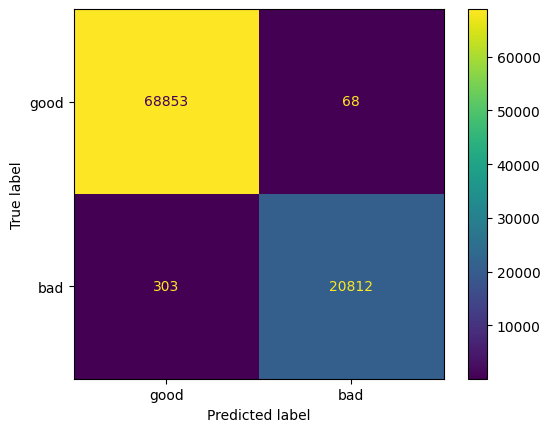

In [36]:
print("===== Modele : Multinomial Naive Bayesian avec CountVectorizer =====")

# Entrainement du modele
mnb_count = MultinomialNB()
mnb_count.fit(count_X, labels)

# Calcule et affiche les résultats
score_mnb_count, f1_mnb_count, recall_mnb_count, pred_labels = results(mnb_count, test_count_X, test_labels)
printResults(score_mnb_count, f1_mnb_count, recall_mnb_count, test_labels, pred_labels)

### Modele : Logistique Regression

===== Modele : Logisitque Regression avec TfidfVectorizer =====
Accuracy :  0.9931360789017726
Score F1 :  0.9851535098255898
Recall :  0.9710632251953587
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     68921
           1       1.00      0.97      0.99     21115

    accuracy                           0.99     90036
   macro avg       1.00      0.99      0.99     90036
weighted avg       0.99      0.99      0.99     90036



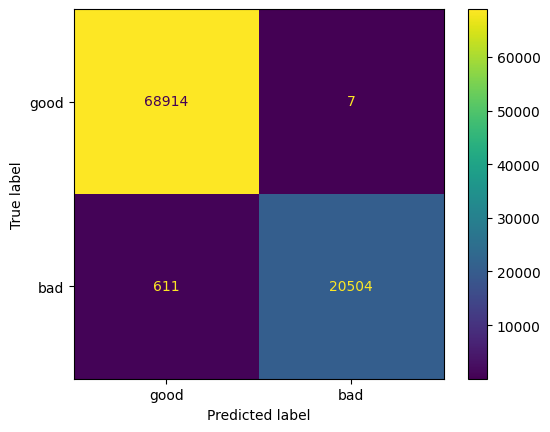

In [37]:
print("===== Modele : Logisitque Regression avec TfidfVectorizer =====")

# Entrainement du modele
lr_tfidf = LogisticRegression(max_iter = 200)
lr_tfidf.fit(tfidf_X, labels)

# Calcule et affiche les résultats
score_lr_tfidf, f1_lr_tfidf, recall_lr_tfidf, pred_labels = results(lr_tfidf, test_tfidf_X, test_labels)
printResults(score_lr_tfidf, f1_lr_tfidf, recall_lr_tfidf, test_labels, pred_labels)

===== Modele : Logistique Regression avec CountVectorizer =====
Accuracy :  0.9948909325158826
Score F1 :  0.9889920551354456
Recall :  0.9786407766990292
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     68921
           1       1.00      0.98      0.99     21115

    accuracy                           0.99     90036
   macro avg       1.00      0.99      0.99     90036
weighted avg       0.99      0.99      0.99     90036



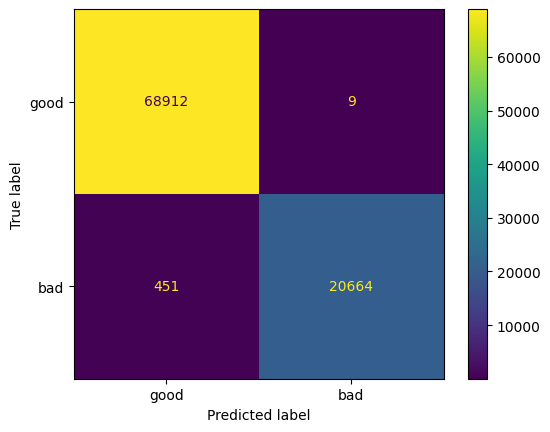

In [38]:
print("===== Modele : Logistique Regression avec CountVectorizer =====")

# Entrainement du modele
lr_count = LogisticRegression(max_iter = 200)
lr_count.fit(count_X, labels)

# Calcule et affiche les résultats
score_lr_count, f1_lr_count, recall_lr_count, pred_labels = results(lr_count, test_count_X, test_labels)
printResults(score_lr_count, f1_lr_count, recall_lr_count, test_labels, pred_labels)

### Modele : RandomForestClassifier

===== Modele : RandomForestClassifier avec TfidfVectorizer =====
Accuracy :  0.7809542849526856
Score F1 :  0.12377821219122087
Recall :  0.06597205777883021
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     68921
           1       1.00      0.07      0.12     21115

    accuracy                           0.78     90036
   macro avg       0.89      0.53      0.50     90036
weighted avg       0.83      0.78      0.70     90036



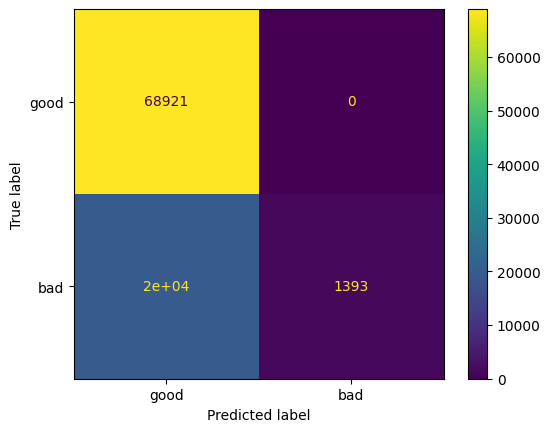

In [39]:
print("===== Modele : RandomForestClassifier avec TfidfVectorizer =====")

# Entrainement du modele
rfc_tfidf = RandomForestClassifier(max_depth=50, random_state=42)
rfc_tfidf.fit(tfidf_X, labels)

# Calcule et affiche les résultats
score_rfc_tfidf, f1_rfc_tfidf, recall_rfc_tfidf, pred_labels = results(rfc_tfidf, test_tfidf_X, test_labels)
printResults(score_rfc_tfidf, f1_rfc_tfidf, recall_rfc_tfidf, test_labels, pred_labels)

===== Modele : RandomForestClassifier avec CountVectorizer =====
Accuracy :  0.784852725576436
Score F1 :  0.1525876022573166
Recall :  0.0825953113900071
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     68921
           1       1.00      0.08      0.15     21115

    accuracy                           0.78     90036
   macro avg       0.89      0.54      0.51     90036
weighted avg       0.83      0.78      0.71     90036



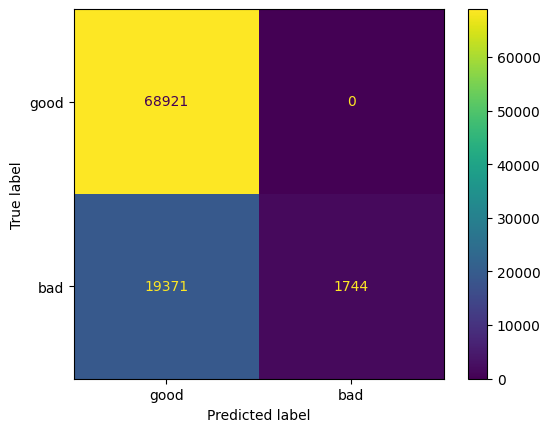

In [40]:
print("===== Modele : RandomForestClassifier avec CountVectorizer =====")

# Entrainement du modele
rfc_count = RandomForestClassifier(max_depth=50, random_state=42)
rfc_count.fit(count_X, labels)

# Calcule et affiche les résultats
score_rfc_count, f1_rfc_count, recall_rfc_count, pred_labels = results(rfc_count, test_count_X, test_labels)
printResults(score_rfc_count, f1_rfc_count, recall_rfc_count, test_labels, pred_labels)

## Sans l'utilisation de 'tokenizer'

In [41]:
#Selection des caracteristiques du dataset
X = train_data[[
                'count-digits', 
                'count-dir', 
                'count.', 
                'count-', 
                'count_', 
                'count@', 
                'count?', 
                'count%',
                'count=', 
                'count-http', 
                'count-https', 
                'count-www', 
                'url_length', 
                'hostname_length', 
                'path_length', 
                'fd_length',
                'use_of_ip'
                ]]

test_X = test_data[[
                    'count-digits', 
                    'count-dir', 
                    'count.', 
                    'count-', 
                    'count_', 
                    'count@', 
                    'count?', 
                    'count%',
                    'count=', 
                    'count-http', 
                    'count-https', 
                    'count-www', 
                    'url_length', 
                    'hostname_length', 
                    'path_length', 
                    'fd_length',
                    'use_of_ip'
                    ]]

===== Modele : Logisitque Regression =====


/home/quentin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy :  0.9961793060553557
Score F1 :  0.9918487275484574
Recall :  0.9911910963769832
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       0.99      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       0.99      0.99      0.99     90036
weighted avg       1.00      1.00      1.00     90036



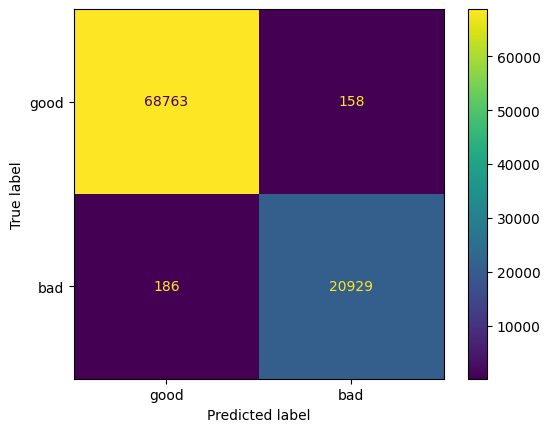

In [42]:
print("===== Modele : Logisitque Regression =====")

# Entrainement du modele
lr = LogisticRegression(max_iter = 300)
lr.fit(X, labels)

# Calcule et affiche les résultats
score_lr, f1_lr, recall_lr, pred_labels = results(lr, test_X, test_labels)
printResults(score_lr, f1_lr, recall_lr, test_labels, pred_labels)

===== Modele : Multinomial Naive Bayesian =====
Accuracy :  0.7945488471278156
Score F1 :  0.4368264019971991
Recall :  0.3397584655458205
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     68921
           1       0.61      0.34      0.44     21115

    accuracy                           0.79     90036
   macro avg       0.72      0.64      0.66     90036
weighted avg       0.77      0.79      0.77     90036



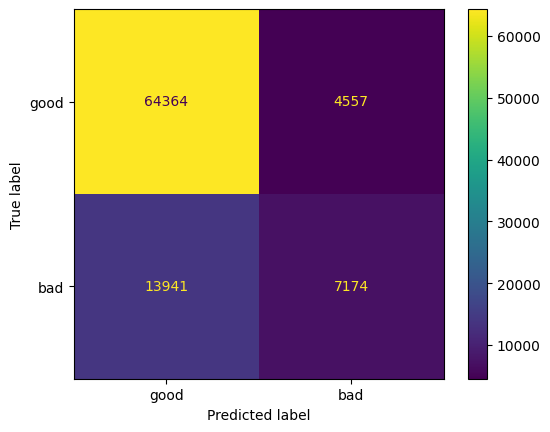

In [43]:
print("===== Modele : Multinomial Naive Bayesian =====")

# Entrainement du modele
mnb = MultinomialNB()
mnb.fit(X, labels)

# Calcule et affiche les résultats
score_mnb, f1_mnb, recall_mnb, pred_labels = results(mnb, test_X, test_labels)
printResults(score_mnb, f1_mnb, recall_mnb, test_labels, pred_labels)

===== Modele : Random Forest Classifier =====
Accuracy :  0.9972677595628415
Score F1 :  0.994158712067246
Recall :  0.9914278948614729
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       1.00      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       1.00      1.00      1.00     90036
weighted avg       1.00      1.00      1.00     90036



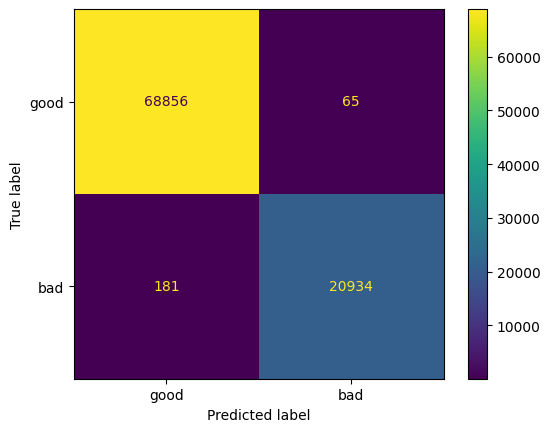

In [44]:
print("===== Modele : Random Forest Classifier =====")

# Entrainement du modele
rfc = RandomForestClassifier()
rfc.fit(X, labels)

# Calcule et affiche les résultats
score_rfc, f1_rfc, recall_rfc, pred_labels = results(rfc, test_X, test_labels)
printResults(score_rfc, f1_rfc, recall_rfc, test_labels, pred_labels)

## Comparaison graphiques des différentes techniques

===== Comparaisons graphiques avec TfidfVectorizer =====


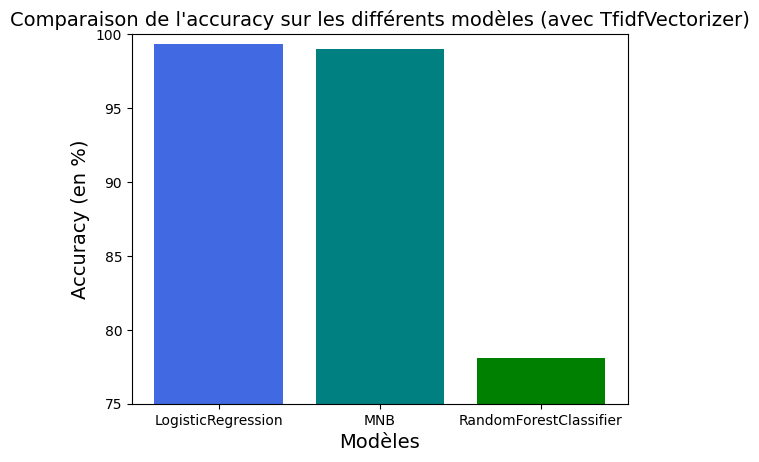

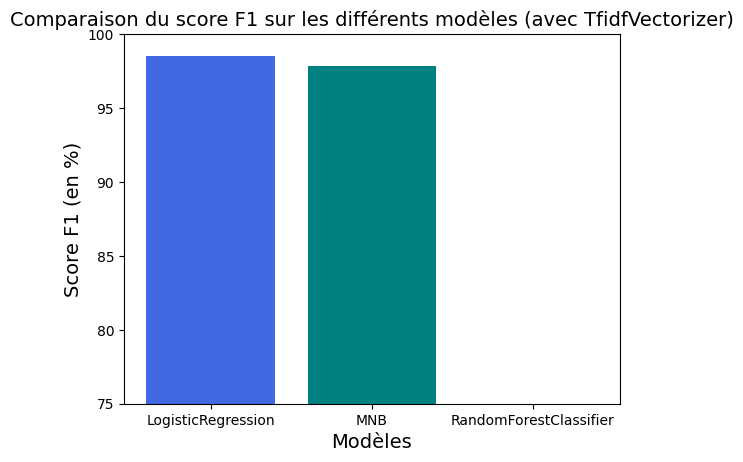

In [45]:
print("===== Comparaisons graphiques avec TfidfVectorizer =====")

labels = ["LogisticRegression", "MNB", "RandomForestClassifier"]

# Accuracy
scores = [score_lr_tfidf, score_mnb_tfidf, score_rfc_tfidf]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison de l'accuracy sur les différents modèles (avec TfidfVectorizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Accuracy (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

# F1 score
scores = [f1_lr_tfidf, f1_mnb_tfidf, f1_rfc_tfidf]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison du score F1 sur les différents modèles (avec TfidfVectorizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Score F1 (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

===== Comparaisons graphiques avec CountVectorizer =====


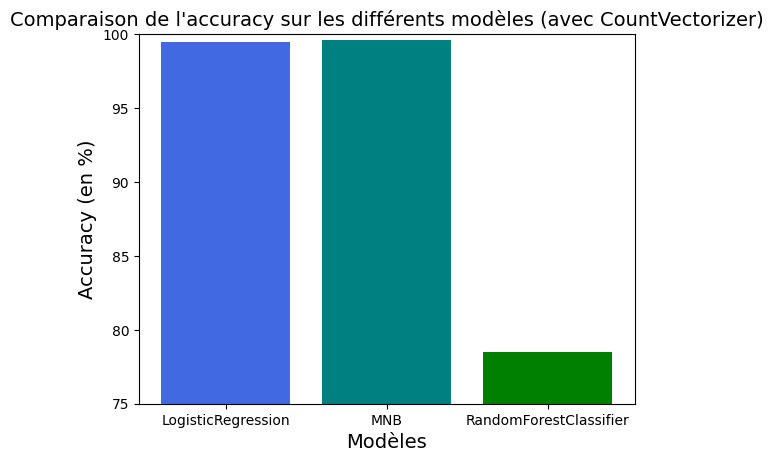

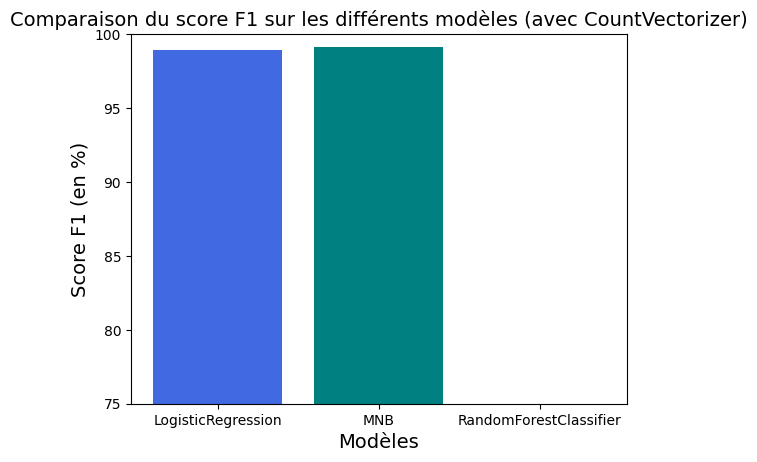

In [46]:
print("===== Comparaisons graphiques avec CountVectorizer =====")

labels = ["LogisticRegression", "MNB", "RandomForestClassifier"]

# Accuracy
scores = [score_lr_count, score_mnb_count, score_rfc_count]
scores = [score * 100 for score in scores]

data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison de l'accuracy sur les différents modèles (avec CountVectorizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Accuracy (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

# F1 score
scores = [f1_lr_count, f1_mnb_count, f1_rfc_count]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison du score F1 sur les différents modèles (avec CountVectorizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Score F1 (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

===== Comparaisons graphiques sans tokenizer =====


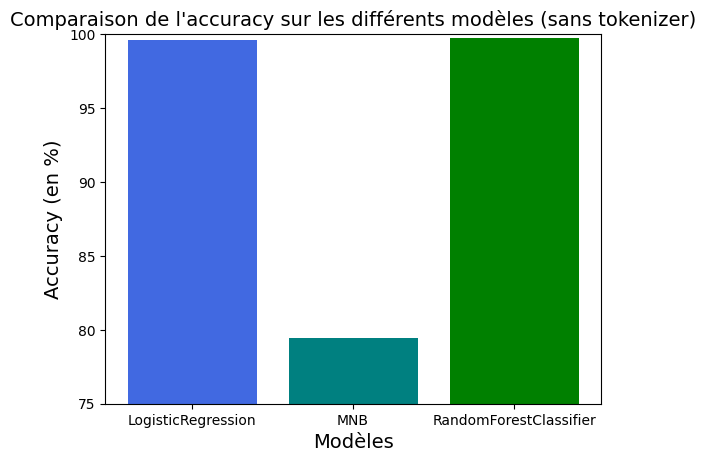

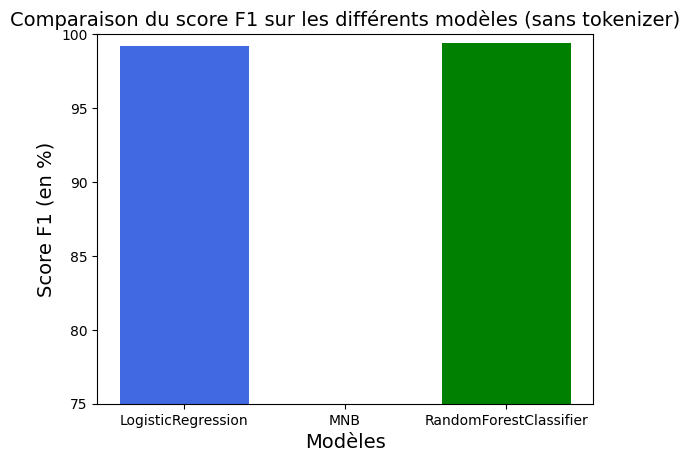

In [47]:
print("===== Comparaisons graphiques sans tokenizer =====")

labels = ["LogisticRegression", "MNB", "RandomForestClassifier"]

# Accuracy
scores = [score_lr, score_mnb, score_rfc]
scores = [score * 100 for score in scores]
   
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

colors = ['royalblue','teal','green']
plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison de l'accuracy sur les différents modèles (sans tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Accuracy (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()

# F1_score
scores = [f1_lr, f1_mnb, f1_rfc]
scores = [score * 100 for score in scores]
data = {'labels': labels,
        'scores': scores
       }
df = pd.DataFrame(data)

plt.bar(df['labels'], df['scores'], color=colors)
plt.title("Comparaison du score F1 sur les différents modèles (sans tokenizer)", fontsize=14)
plt.xlabel('Modèles', fontsize=14)
plt.ylabel('Score F1 (en %)', fontsize=14)
plt.ylim((75,100))
plt.show()